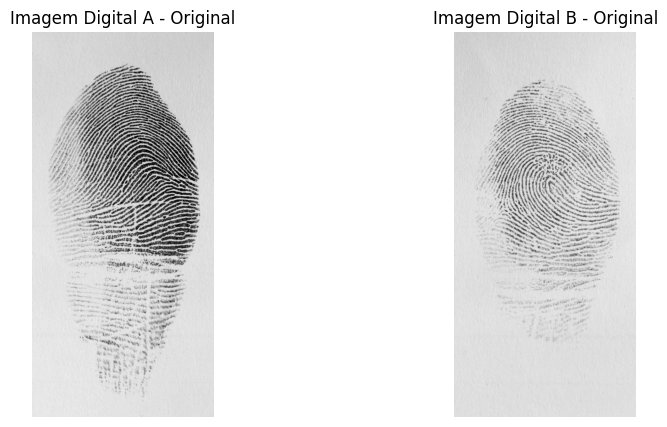

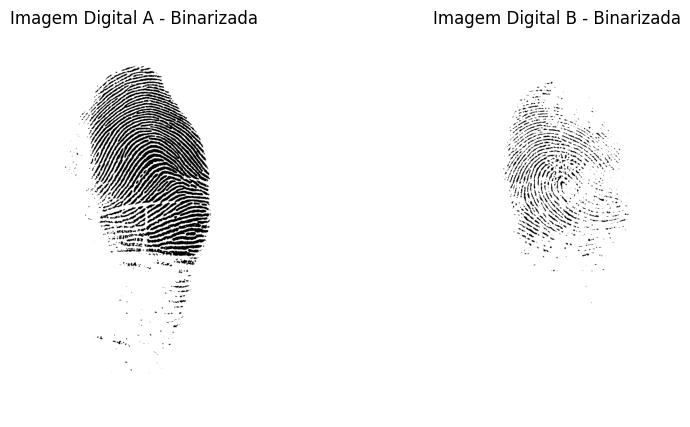

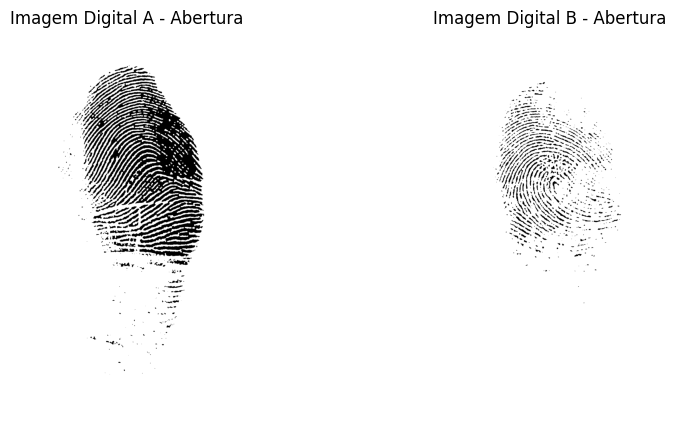

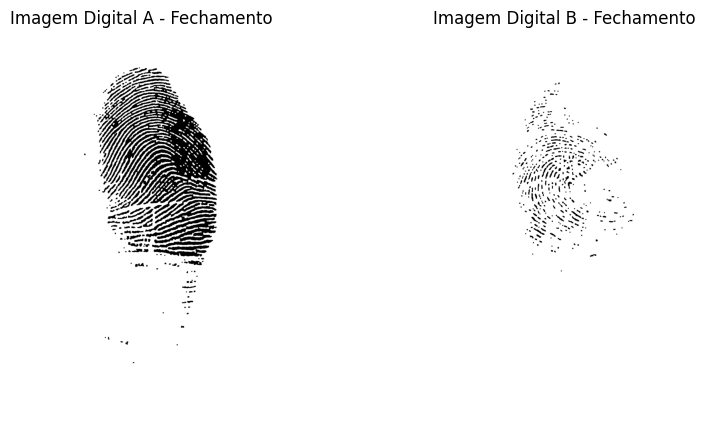

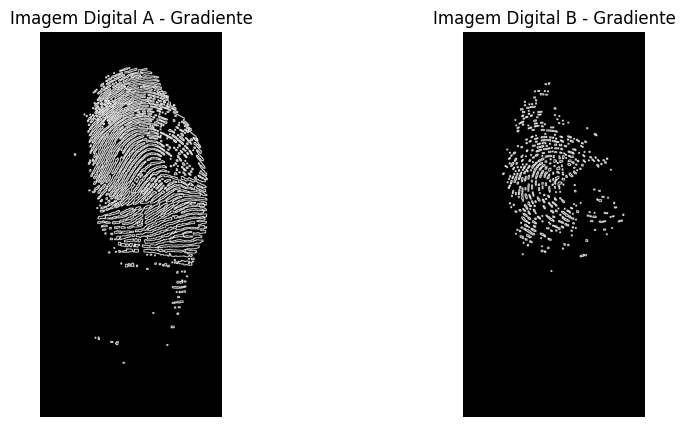

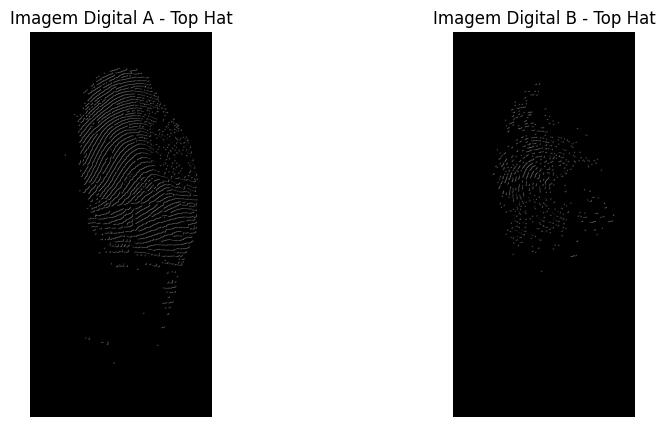

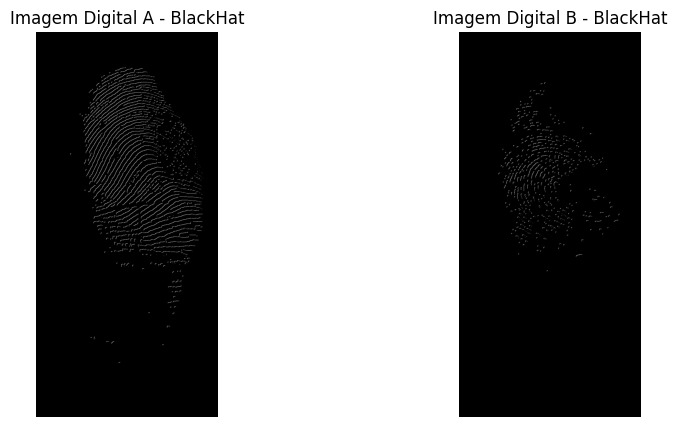

0.16883364713175944
0.11479892441573866
0.20210571675716044
0.038222767577268606
0.03898031030789255
0.11258827323796392


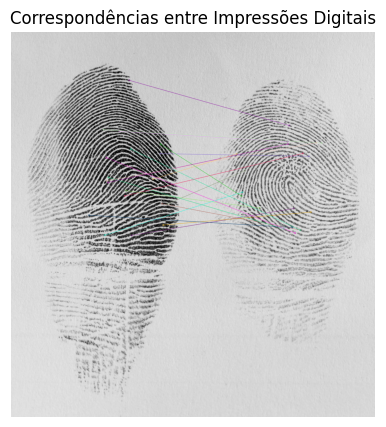

Sem Correspondência


In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# morfologia

# Função para exibir duas imagens lado a lado
def show_images_side_by_side(title1, img1, title2, img2):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.title(title1)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap='gray')
    plt.title(title2)
    plt.axis('off')

    plt.show()

# Função para exibir uma única imagem
def show_image(title, img):
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Função para exibir imagens comparadas com correspondências de keypoints
def show_matches(img1, img2, kp1, kp2, matches):
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(10, 5))
    plt.imshow(img_matches)
    plt.title("Correspondências entre Impressões Digitais")
    plt.axis('off')
    plt.show()

# Função para calcular a similaridade entre duas imagens usando o coeficiente de correlação
def compare_images_partial_rotated(img1, img2, max_angle=15, step=1, sliding_window_step=10):
    def rotate_image(image, angle):
        center = tuple(np.array(image.shape[1::-1]) / 2)
        rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, rot_matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR)
        return rotated

    max_correlation = -1

    for angle in range(-max_angle, max_angle + 1, step):
        rotated_img2 = rotate_image(img2, angle)

        for y in range(0, rotated_img2.shape[0] - img1.shape[0] + 1, sliding_window_step):
            for x in range(0, rotated_img2.shape[1] - img1.shape[1] + 1, sliding_window_step):
                sub_image = rotated_img2[y:y + img1.shape[0], x:x + img1.shape[1]]

                if sub_image.shape != img1.shape:
                    continue

                correlation = np.corrcoef(img1.ravel(), sub_image.ravel())[0, 1]

                if correlation > max_correlation:
                    max_correlation = correlation

    if max_correlation == -1:
        print("Nenhuma correspondência válida foi encontrada entre as imagens.")
    
    return max_correlation

# Carregar as duas imagens de impressões digitais
img1 = cv2.imread("digital_a.png", 0)  # Carrega a imagem em escala de cinza
img2 = cv2.imread("digital_b.png", 0)  # Carrega a imagem em escala de cinza

# Redimensionar imagens para o mesmo tamanho
height, width = img1.shape[:2]
img2 = cv2.resize(img2, (width, height))

# Exibir imagens originais lado a lado
show_images_side_by_side("Imagem Digital A - Original", img1, "Imagem Digital B - Original", img2)

# Suavização (Blur) para reduzir o ruído
img1_blurred = cv2.GaussianBlur(img1, (5, 5), 0)
img2_blurred = cv2.GaussianBlur(img2, (5, 5), 0)

# Limiarização (Thresholding) para binarizar as imagens
_, img1_thresh = cv2.threshold(img1_blurred, 127, 255, cv2.THRESH_BINARY)
_, img2_thresh = cv2.threshold(img2_blurred, 127, 255, cv2.THRESH_BINARY)

# Exibir imagens binarizadas lado a lado
show_images_side_by_side("Imagem Digital A - Binarizada", img1_thresh, "Imagem Digital B - Binarizada", img2_thresh)

# Kernel para operações morfológicas
kernel = np.ones((4, 4), np.uint8)

# Abertura (Opening) - Remover ruídos
img1_opening = cv2.morphologyEx(img1_thresh, cv2.MORPH_OPEN, kernel)
img2_opening = cv2.morphologyEx(img2_thresh, cv2.MORPH_OPEN, kernel)

show_images_side_by_side("Imagem Digital A - Abertura", img1_opening, "Imagem Digital B - Abertura", img2_opening)

# Fechamento (Closing) - Preencher falhas
img1_closing = cv2.morphologyEx(img1_opening, cv2.MORPH_CLOSE, kernel)
img2_closing = cv2.morphologyEx(img2_opening, cv2.MORPH_CLOSE, kernel)

show_images_side_by_side("Imagem Digital A - Fechamento", img1_closing, "Imagem Digital B - Fechamento", img2_closing)

# Gradiente Morfológico - Realçar contornos
img1_gradient = cv2.morphologyEx(img1_closing, cv2.MORPH_GRADIENT, kernel)
img2_gradient = cv2.morphologyEx(img2_closing, cv2.MORPH_GRADIENT, kernel)

show_images_side_by_side("Imagem Digital A - Gradiente", img1_gradient, "Imagem Digital B - Gradiente", img2_gradient)

# Top Hat - Destaque de regiões claras
img1_tophat = cv2.morphologyEx(img1_closing, cv2.MORPH_TOPHAT, kernel)
img2_tophat = cv2.morphologyEx(img2_closing, cv2.MORPH_TOPHAT, kernel)

show_images_side_by_side("Imagem Digital A - Top Hat", img1_tophat, "Imagem Digital B - Top Hat", img2_tophat)

# Black Hat - Destaque de regiões escuras
img1_blackhat = cv2.morphologyEx(img1_closing, cv2.MORPH_BLACKHAT, kernel)
img2_blackhat = cv2.morphologyEx(img2_closing, cv2.MORPH_BLACKHAT, kernel)

show_images_side_by_side("Imagem Digital A - BlackHat", img1_blackhat, "Imagem Digital B - BlackHat", img2_blackhat)

# Comparação usando coeficiente de correlação com rotação e correspondência de padrões parciais
correlation_opening = compare_images_partial_rotated(img1_opening, img2_opening)
correlation_closing = compare_images_partial_rotated(img1_closing, img2_closing)
correlation_gradient = compare_images_partial_rotated(img1_gradient, img2_gradient)
correlation_tophat = compare_images_partial_rotated(img1_tophat, img2_tophat)
correlation_blackhat = compare_images_partial_rotated(img1_blackhat, img2_blackhat)

# Média das correlações para decisão final
average_correlation = (correlation_opening + correlation_closing + correlation_gradient + correlation_tophat + correlation_blackhat) / 5

print(correlation_opening)
print(correlation_closing)
print(correlation_gradient)
print(correlation_tophat)
print(correlation_blackhat)
print(average_correlation)

# Comparação usando ORB (Oriented FAST and Rotated BRIEF)
orb = cv2.ORB_create()

# Detectar keypoints e calcular descritores
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Usar BFMatcher para encontrar correspondências
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Exibir correspondências entre as imagens
show_matches(img1, img2, kp1, kp2, matches[:20])  # Mostrar as 20 melhores correspondências

# Definir um limiar para decidir se as impressões digitais são semelhantes
similarity_threshold = 0.3  # Ajuste este valor conforme necessário

if average_correlation > similarity_threshold:
    print("Digitais Correspondentes")
else:
    print("Sem Correspondência")
